In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit import transpile
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap
from qiskit.visualization import plot_histogram

In [3]:
def zz_feature_map(x):
    n = len(x)  # Number of features (qubits)
    qc = QuantumCircuit(n)

    # Step 1: Apply Hadamard gates
    for i in range(n):
        qc.h(i)

    # Step 2: Encode the individual features
    for i in range(n):
        qc.rz(2 * x[i], i)

    # Step 3: Encode pairwise interactions
    for i in range(n):
        for j in range(i + 1, n):
            qc.cx(i, j)
            qc.rz(2 * x[i] * x[j], j)
            qc.cx(i, j)  # Undo the CX gate

    return qc



In [4]:
def cswap_test(circuit1, circuit2):
    n = circuit1.num_qubits  # Number of qubits in each encoded circuit

    # Create a new circuit: 1 ancilla + qubits for circuit1 + qubits for circuit2
    qc = QuantumCircuit(1 + 2 * n, 1)

    # Add the encoded circuits
    qc.compose(circuit1, qubits=range(1, n + 1), inplace=True)
    qc.compose(circuit2, qubits=range(n + 1, 2 * n + 1), inplace=True)

    # Hadamard on the ancilla
    qc.h(0)

    # CSWAP Gates (Controlled SWAP between corresponding qubits)
    for i in range(n):
        qc.cswap(0, i + 1, i + 1 + n)

    # Second Hadamard on the ancilla
    qc.h(0)

    # Measurement
    qc.measure(0, 0)

    return qc

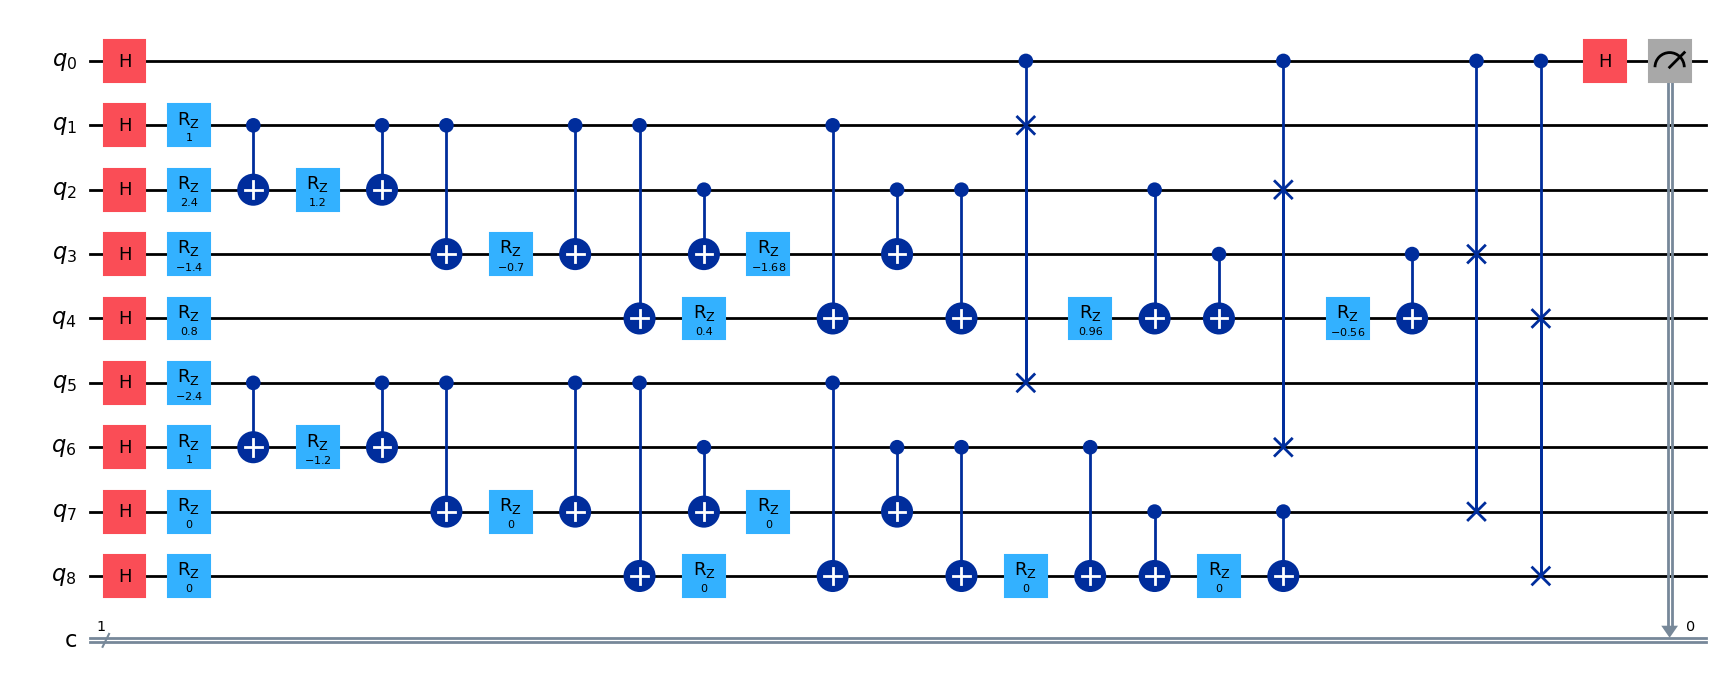

In [5]:
# Example usage
x1 = [0.5, 1.2, -0.7, 0.4]  # Sample input vector
x2 = [-1.2, 0.5, 0, 0]   # Sample input vector

qc1 = zz_feature_map(x1)
qc2 = zz_feature_map(x2)

cswap = cswap_test(qc1, qc2)

# Generate a 5-qubit simulated backend
backend = GenericBackendV2(num_qubits=qc1.num_qubits * 2 + 1)

# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(cswap, backend)

# Run the transpiled circuit using the simulated backend
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()
# plot_histogram(counts)

cswap.draw(output="mpl")
# transpiled_circuit.draw('mpl')

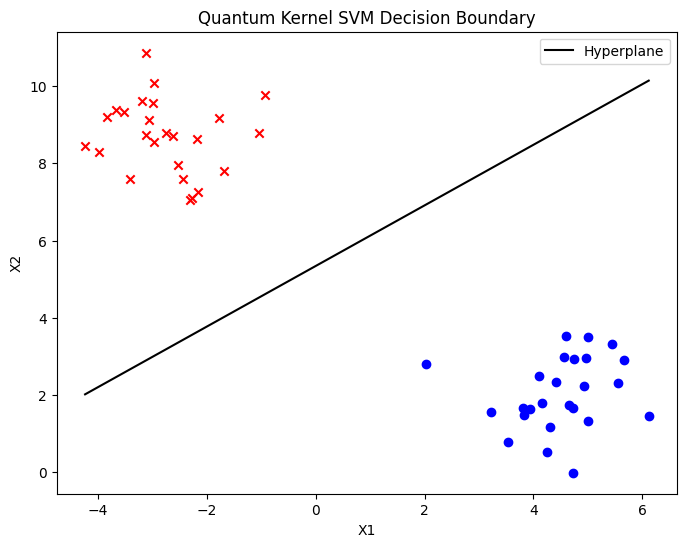

Optimal alphas: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.84829934e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.46080594e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.73006686e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.46944695e-18
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.20961586e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Bias term: 1.2926502993958726
Weight vector approximation: [ 0.19002748 -0.24204427]


In [6]:
# Generate synthetic linearly separable data
X, y = make_blobs(n_samples=50, centers=2, n_features=2, random_state=42)

# Convert labels from {0,1} to {-1,1} for SVM compatibility
y = 2 * y - 1

# Number of samples
n_samples = X.shape[0]

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

# Compute classical kernel matrix
K_classic = np.array([[linear_kernel(x_i, x_j) for x_j in X] for x_i in X])
# Compute quantum kernel matrix
# K_quantum = quantum_kernel.evaluate(X)
# K_quantum = compute_quantum_kernel_matrix(X=X, print_circuit=True)


# Initialize variables
alpha = np.zeros(n_samples)
b = 0
C = 1.0  # Regularization parameter
tol = 1e-5  # Tolerance for stopping criteria
max_iter = 1000  # Maximum iterations

def smo(K):
    global alpha, b
    for _ in range(max_iter):
        num_changed_alphas = 0
        for i in range(n_samples):
            E_i = np.sum(alpha * y * K[i, :]) + b - y[i]
            if (y[i] * E_i < -tol and alpha[i] < C) or (y[i] * E_i > tol and alpha[i] > 0):
                j = np.random.choice([idx for idx in range(n_samples) if idx != i])
                E_j = np.sum(alpha * y * K[j, :]) + b - y[j]
                
                alpha_i_old, alpha_j_old = alpha[i], alpha[j]
                
                if y[i] != y[j]:
                    L, H = max(0, alpha[j] - alpha[i]), min(C, C + alpha[j] - alpha[i])
                else:
                    L, H = max(0, alpha[i] + alpha[j] - C), min(C, alpha[i] + alpha[j])
                
                if L == H:
                    continue
                
                eta = 2 * K[i, j] - K[i, i] - K[j, j]
                if eta >= 0:
                    continue
                
                alpha[j] -= y[j] * (E_i - E_j) / eta
                alpha[j] = np.clip(alpha[j], L, H)
                
                if abs(alpha[j] - alpha_j_old) < tol:
                    continue
                
                alpha[i] += y[i] * y[j] * (alpha_j_old - alpha[j])
                
                b1 = b - E_i - y[i] * (alpha[i] - alpha_i_old) * K[i, i] - y[j] * (alpha[j] - alpha_j_old) * K[i, j]
                b2 = b - E_j - y[i] * (alpha[i] - alpha_i_old) * K[i, j] - y[j] * (alpha[j] - alpha_j_old) * K[j, j]
                
                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2
                
                num_changed_alphas += 1
        
        if num_changed_alphas == 0:
            break

smo(K_classic)
# smo(K_quantum)

# Compute weight vector approximation
w = np.sum((alpha * y)[:, np.newaxis] * X, axis=0)

# Plot data and decision boundary
plt.figure(figsize=(8, 6))
for i, point in enumerate(X):
    if y[i] == 1:
        plt.scatter(point[0], point[1], color='blue', marker='o')
    else:
        plt.scatter(point[0], point[1], color='red', marker='x')

# Decision boundary
x1_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2_vals = (-w[0] * x1_vals - b) / w[1]
plt.plot(x1_vals, x2_vals, color='black', label='Hyperplane')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('Quantum Kernel SVM Decision Boundary')
# sys.stdout.flush()
plt.show()

print("Optimal alphas:", alpha)
print("Bias term:", b)
print("Weight vector approximation:", w)